In [1]:
import numpy
import pandas
import matplotlib
import sklearn.datasets as sklearn_datasets

In [2]:
def normalize(data):
    min_value = numpy.ndarray.min(data)
    max_value = numpy.ndarray.max(data)
    
    return (data - min_value) / (max_value - min_value)

In [3]:
def sigmoid_activate(total_sum):
    return 1 / (1 + numpy.exp(-total_sum))

In [4]:
def binary_step_activate(total_sum, center_value):
    return 1 if total_sum > center_value else 0

In [5]:
def update_weights(weights, errors, learning_rate):
    return weights + learning_rate * errors

In [6]:
def intercept_sigmoid_derivative(sigmoid_value):
    return sigmoid_value * (1 - sigmoid_value)

In [7]:
def slope_sigmoid_derivative(inputs, total_sums, sigmoid_value):
    return inputs.sum() * numpy.exp(-total_sums) * sigmoid_value**2

In [8]:
data_len = 300
feature_len = 5
index_offset = 50

### Setup & Preview

In [9]:
dataset = sklearn_datasets.load_breast_cancer()
data = dataset.data[index_offset:data_len + index_offset, :feature_len]
target = dataset.target[index_offset:data_len + index_offset]

data_with_target = numpy.c_[data, target]
features_with_target = numpy.append(dataset.feature_names[:feature_len], ['target'])

In [10]:
data_with_target[:20]

array([[1.176e+01, 2.160e+01, 7.472e+01, 4.279e+02, 8.637e-02, 1.000e+00],
       [1.364e+01, 1.634e+01, 8.721e+01, 5.718e+02, 7.685e-02, 1.000e+00],
       [1.194e+01, 1.824e+01, 7.571e+01, 4.376e+02, 8.261e-02, 1.000e+00],
       [1.822e+01, 1.870e+01, 1.203e+02, 1.033e+03, 1.148e-01, 0.000e+00],
       [1.510e+01, 2.202e+01, 9.726e+01, 7.128e+02, 9.056e-02, 0.000e+00],
       [1.152e+01, 1.875e+01, 7.334e+01, 4.090e+02, 9.524e-02, 1.000e+00],
       [1.921e+01, 1.857e+01, 1.255e+02, 1.152e+03, 1.053e-01, 0.000e+00],
       [1.471e+01, 2.159e+01, 9.555e+01, 6.569e+02, 1.137e-01, 0.000e+00],
       [1.305e+01, 1.931e+01, 8.261e+01, 5.272e+02, 8.060e-02, 1.000e+00],
       [8.618e+00, 1.179e+01, 5.434e+01, 2.245e+02, 9.752e-02, 1.000e+00],
       [1.017e+01, 1.488e+01, 6.455e+01, 3.119e+02, 1.134e-01, 1.000e+00],
       [8.598e+00, 2.098e+01, 5.466e+01, 2.218e+02, 1.243e-01, 1.000e+00],
       [1.425e+01, 2.215e+01, 9.642e+01, 6.457e+02, 1.049e-01, 0.000e+00],
       [9.173e+00, 1.386e

In [11]:
features_with_target

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'target'], dtype='<U23')

In [12]:
dataframe = pandas.DataFrame(data=data_with_target, columns=features_with_target)
dataframe.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        11.76         21.60           74.72      427.9          0.08637   
1        13.64         16.34           87.21      571.8          0.07685   
2        11.94         18.24           75.71      437.6          0.08261   
3        18.22         18.70          120.30     1033.0          0.11480   
4        15.10         22.02           97.26      712.8          0.09056   

   target  
0     1.0  
1     1.0  
2     1.0  
3     0.0  
4     0.0

In [26]:
# initial weights
# additional 1 to feature_len are bias
learning_rate = 0.1
threshold = 10000
weights = numpy.random.uniform(size=(feature_len + 1), low=0.0, high=1.0)
weights

array([0.18642996, 0.18894561, 0.16058776, 0.3434229 , 0.36589308,
       0.33324898])

In [27]:
normalized_data = normalize(data)
normalized_data[:10]

array([[4.68098544e-03, 8.61865896e-03, 2.98756933e-02, 1.71207760e-01,
        9.54805796e-06],
       [5.43330518e-03, 6.51376438e-03, 3.48738175e-02, 2.28792234e-01,
        5.73843886e-06],
       [4.75301605e-03, 7.27408752e-03, 3.02718617e-02, 1.75089410e-01,
        8.04341849e-06],
       [7.26608411e-03, 7.45816575e-03, 4.81154453e-02, 4.13350672e-01,
        2.09248932e-05],
       [6.01755348e-03, 8.78673040e-03, 3.88955268e-02, 2.85216214e-01,
        1.12247706e-05],
       [4.58494462e-03, 7.47817425e-03, 2.93234586e-02, 1.63644546e-01,
        1.30975665e-05],
       [7.66225249e-03, 7.40614364e-03, 5.01963296e-02, 4.60970910e-01,
        1.71232775e-05],
       [5.86148716e-03, 8.61465726e-03, 3.82112359e-02, 2.62846707e-01,
        2.04847061e-05],
       [5.19720483e-03, 7.70226950e-03, 3.30330352e-02, 2.10944648e-01,
        7.23907664e-06],
       [3.42365107e-03, 4.69299054e-03, 2.17202272e-02, 8.98131670e-02,
        1.40099543e-05]])

In [28]:
# weight and data shapes
# NOTE: we want element wise multiplication not matrix dot product
# the tweak can be done to make into 1x1 are doing 1xm * nx1 where m = n
print(weights.shape, 'x', normalized_data[0].shape)

(6,) x (5,)


In [29]:
total_sum_0 = (weights[1:] * normalized_data[0]).sum() + weights[0]
total_sum_0

0.2616053782911844

In [30]:
perceptron_0 = sigmoid_activate(total_sum_0)
perceptron_0

0.5650308883154507

### TRAINING

### Batch Gradient Descent

In [31]:
errors = []
average_factor = 1 / (2 * normalized_data.shape[0])

for _ in range(threshold):
    total_sums = numpy.array([(x * weights[1:]).sum() + weights[0] for x in normalized_data])
    predicts = numpy.array([sigmoid_activate(total_sum) for total_sum in total_sums])

    costs = target - predicts

    for n in range(predicts.shape[0]):
        weights[0] += learning_rate * intercept_sigmoid_derivative(predicts[n]) * costs[n]
        weights[1:] += learning_rate * slope_sigmoid_derivative(normalized_data[n], total_sums[n], predicts[n]) * costs[n]
        
    errors.append(average_factor * (costs**2).sum())

In [20]:
weights

array([  3.99089538, -11.2289562 , -11.27010237, -11.57540662,
       -11.69324512, -11.26411572])

In [21]:
learning_dataframe = pandas.DataFrame(data=errors, columns=['Average Costs'])
learning_dataframe.index.name = 'Epoch'
learning_dataframe.head(20)

Average Costs
Epoch               
0           0.127090
1           0.125516
2           0.124156
3           0.122988
4           0.121981
5           0.121107
6           0.120336
7           0.119646
8           0.119017
9           0.118433
10          0.117882
11          0.117355
12          0.116847
13          0.116351
14          0.115866
15          0.115388
16          0.114917
17          0.114451
18          0.113989
19          0.113532

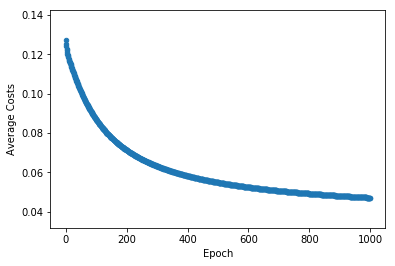

In [23]:
learning_dataframe.reset_index().plot(kind='scatter', x='Epoch', y='Average Costs')
matplotlib.pyplot.show()

### Testing

In [24]:
# take weights starting from 1 ignoring bias
testing_weights = weights[1:]

testing_data = normalize(data[:10, :feature_len])
testing_target = target[:10]

In [25]:
testing_data_sums = numpy.sum(testing_weights * testing_data, axis=1)
results = [sigmoid_activate(x) for x in testing_data_sums]

testing_dataframe = pandas.DataFrame(data={'Predict': results, 'Target': testing_target})
testing_dataframe

Predict  Target
0  0.004419       1
1  0.000938       1
2  0.004091       1
3  0.000006       0
4  0.000189       0
5  0.005587       1
6  0.000002       0
7  0.000342       0
8  0.001509       1
9  0.046465       1